<span>
<b>Authors:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a>, <a href="https://andreafailla.github.io/">Andrea Failla</a><br/>
<b>Python version:</b>  >=3.7<br/>
<b>Networkx version:</b>  >=2.3<br/>
<b>Last update:</b> 03/07/2025
</span>

<a id='top'></a>
# Ties Strength & Resilience*

In this notebook are introduced some of the main analysis discussed in lecture 7.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Reading Game of Thrones Season 6 edge data and defining the graph g (useful for further operations)

In [1]:
!git clone https://github.com/sna-unipi/SNA-lectures-notebooks.git
!mkdir asioaf
!cp -r SNA-lectures-notebooks/data/asioaf/* asioaf/
!rm -rf SNA-lectures-notebooks

Clone in 'SNA-lectures-notebooks' in corso...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 264 (delta 10), reused 9 (delta 9), pack-reused 249 (from 1)
Ricezione degli oggetti: 100% (264/264), 8.89 MiB | 3.49 MiB/s, fatto.
Risoluzione dei delta: 100% (113/113), fatto.


In [2]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

# Game of Thrones data
season = 6
g = read_net_w(f'asioaf/got-s{season}-edges.csv')

## Bridges and Local Bridges

Checking if graph has bridges

In [3]:
nx.has_bridges(g)

True

Generating all bridges in the graph

In [4]:
list(nx.bridges(g))

[('JON', 'SAM'),
 ('JON', 'JEOR'),
 ('MISSANDEI', 'KRAZNYS_MO_NAKLOZ'),
 ('TYRION', 'AERYS'),
 ('DAVOS', 'SHIREEN'),
 ('SAM', 'MAESTER_AEMON'),
 ('CERSEI', 'MOUNTAIN'),
 ('TORMUND', 'MANCE'),
 ('HOUND', 'GATINS'),
 ('BRYNDEN', 'MINISA'),
 ('EDMURE', 'HOSTER'),
 ('QYBURN', 'ARTHUR_CHILD'),
 ('NED', 'RICKARD_STARK')]

Generating all local bridges in the graph and computing the span (i.e., the shortest path length between the endpoints if the local bridge is removed)

In [5]:
list(nx.local_bridges(g, with_span=True))

[('JON', 'SAM', inf),
 ('JON', 'JEOR', inf),
 ('MISSANDEI', 'KRAZNYS_MO_NAKLOZ', inf),
 ('TYRION', 'AERYS', inf),
 ('VARYS', 'STANNIS', 3),
 ('ARYA', 'WALDER', 3),
 ('DAVOS', 'SHIREEN', inf),
 ('SAM', 'MAESTER_AEMON', inf),
 ('CERSEI', 'MOUNTAIN', inf),
 ('TORMUND', 'MANCE', inf),
 ('HOUND', 'GATINS', inf),
 ('BRYNDEN', 'MINISA', inf),
 ('EDMURE', 'HOSTER', inf),
 ('QYBURN', 'ARTHUR_CHILD', inf),
 ('NED', 'RICKARD_STARK', inf)]

In [6]:
# add to edges
for u, v, span in nx.local_bridges(g, with_span=True):
    g[u][v]['span'] = span

## Tie Strength

Measuring Tie Strength for each pair of nodes in the graph through Neighborhood Overlap

In [7]:
def neighborhood_overlap(G, u, v):
    """
    Compute overlap O_uv = |N(u) ∩ N(v)| / |N(u) ∪ N(v)|
    (excluding u,v themselves).
    """
    nbrs_u = set(G[u]) - {v}
    nbrs_v = set(G[v]) - {u}
    inter = nbrs_u & nbrs_v
    union = nbrs_u | nbrs_v
    return len(inter) / len(union) if union else 0.0


In [8]:
for u, v in g.edges():
    g[u][v]['overlap'] = neighborhood_overlap(g, u, v)

Plotting the KDE (Kernel Density Estimation) of Neighborhood Overlap

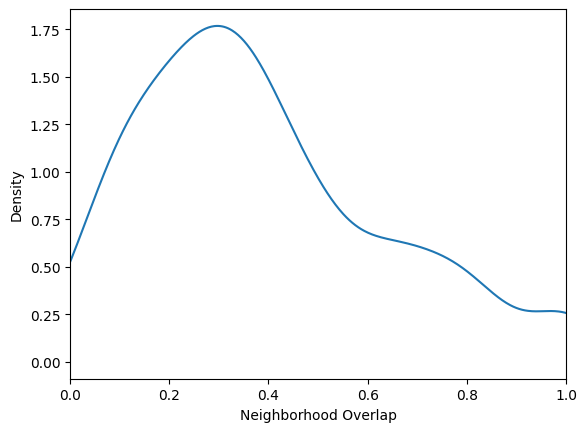

In [9]:
weights = [e[-1]['overlap'] for e in g.edges(data=True)]
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.ylabel("Density")
plt.xlim(0,1)
plt.show()

Plotting the KDE (Kernel Density Estimation) of Interactions Weights

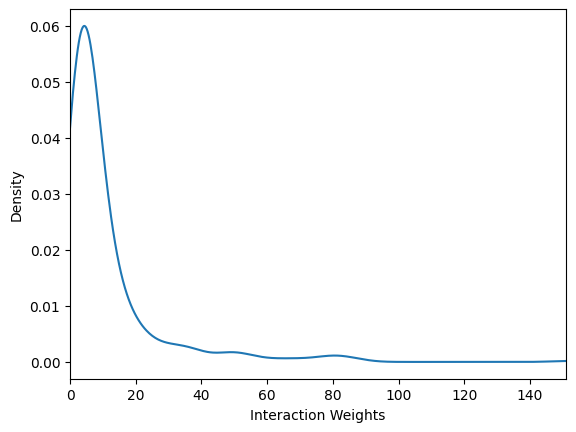

In [10]:
weights_got = [d['weight'] for u,v,d in g.edges(data=True)]
pd.DataFrame(weights_got)[0].plot.kde()
plt.xlabel("Interaction Weights")
plt.ylabel("Density")
plt.xlim(0,max(weights_got))
plt.show()

## Network Resilience
In the following we:
- generate Random and Scale-free Network
- compute Reslience for both Networks (through molloy_reed and breakdown_threshold)
- plot Game of Thrones graph Resilience under Random Failure and Targeted Attacks

Generating Networks

In [11]:
# Random
er = nx.erdos_renyi_graph(1000, 0.001)
# Scale-free
ba = nx.barabasi_albert_graph(1000, 2)

Computing node degree for both ER and BA Networks

In [12]:
er_degs = list(dict(er.degree()).values())
ba_degs = list(dict(ba.degree()).values())

Defining Molloy-Reed threshold

In [13]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

Random network

In [14]:
molloy_reed(er_degs)

2.0220000000000002

In [15]:
breakdown_threshold(er_degs)

0.021526418786693036

Scale-free network

In [16]:
molloy_reed(ba_degs)

4.992

In [17]:
breakdown_threshold(ba_degs)

0.7494989979959921

### Random Failures

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def random_node(g): # select a random node from graph
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # incrementally removes node from a graph and computes size of connected components
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) > 1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size  = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # sort nodes
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]

def plot_dismantle(x, y, ax=None, **kwargs):
    """
    Plot dismantling results on a given axis or create new plot.

    Parameters:
    -----------
    x : list or array
        X-axis data (removed nodes)
    y : list or array
        Y-axis data (giant component size)
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. If None, creates new figure
    **kwargs : dict
        Additional keyword arguments passed to plot function
    """
    if ax is None:
        fig, ax = plt.subplots()
        show_plot = True
    else:
        show_plot = False

    ax.plot(x, y, **kwargs)
    ax.set_xlabel("Removed Nodes")
    ax.set_ylabel("Giant Component size")

    if show_plot:
        plt.show()


Random Failure:
- Giant component size has a consistent decrease when a big fraction of nodes is removed

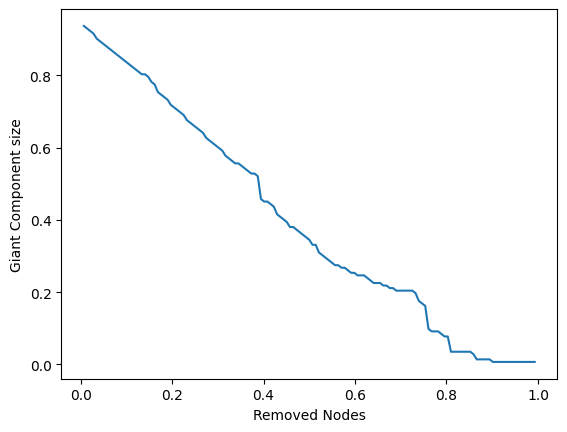

In [19]:
h = g.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps)

### Targeted Attacks

Targeted Node attack (hubs are removed first)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

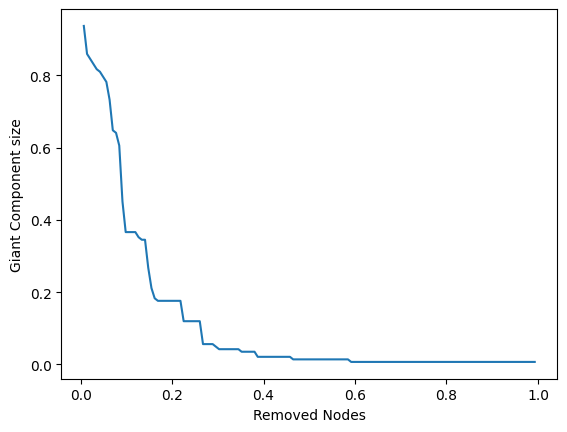

In [20]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Betweenness Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

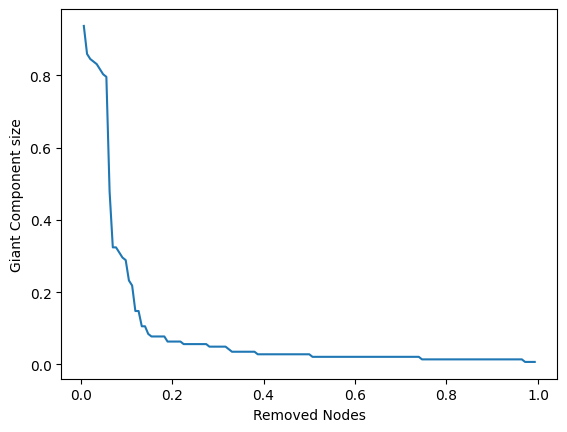

In [21]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Harmonic Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

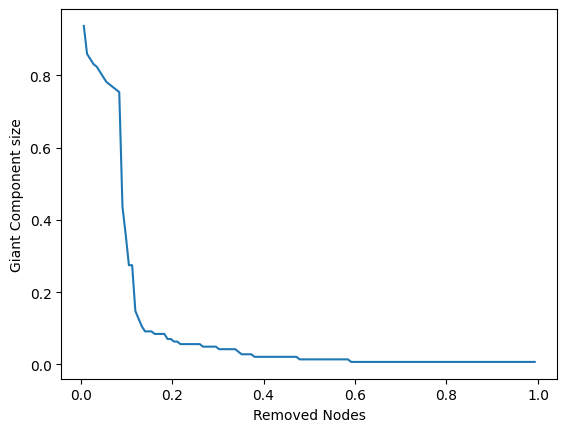

In [22]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.harmonic_centrality)
plot_dismantle(rn, comps)

## Exercises

### Tie strength over time
Load the Game of Thrones networks for different seasons (seasons 1-6)
- For each season, compute the neighborhood overlap for all edges
- Create visualizations comparing the distribution of tie strengths across seasons

In [23]:
import os
data_dir = "asioaf"   # adjust to wherever your got-sX-edges.csv live
season_overlaps = {}

for s in range(1, 7):
    path = os.path.join(data_dir, f"got-s{s}-edges.csv")
    G = read_net_w(path)
    # compute overlap for every edge
    vals = [neighborhood_overlap(G, u, v) for u, v in G.edges()]
    season_overlaps[f"Season {s}"] = vals




In [24]:
# assemble into a DataFrame
df = pd.DataFrame(dict(
    (season, pd.Series(vals))
    for season, vals in season_overlaps.items()
))

In [29]:
df

,Season 1,Season 2,Season 3,Season 4,Season 5,Season 6
0,0.516667,0.631579,0.666667,0.615385,0.500000,0.468085
1,0.446429,0.454545,0.555556,0.266667,0.200000,0.677419
2,0.333333,0.666667,0.222222,0.166667,0.461538,0.400000
3,0.383333,0.361111,0.611111,0.000000,0.500000,0.612903
4,0.500000,0.366667,0.545455,0.086957,0.266667,0.366667
...,...,...,...,...,...,...
662,NaN,NaN,NaN,0.111111,NaN,NaN
663,NaN,NaN,NaN,1.000000,NaN,NaN
664,NaN,NaN,NaN,1.000000,NaN,NaN
665,NaN,NaN,NaN,1.000000,NaN,NaN


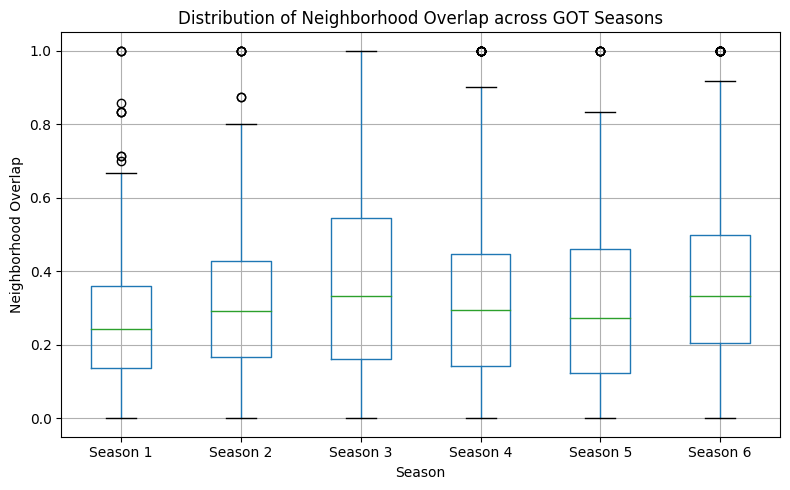

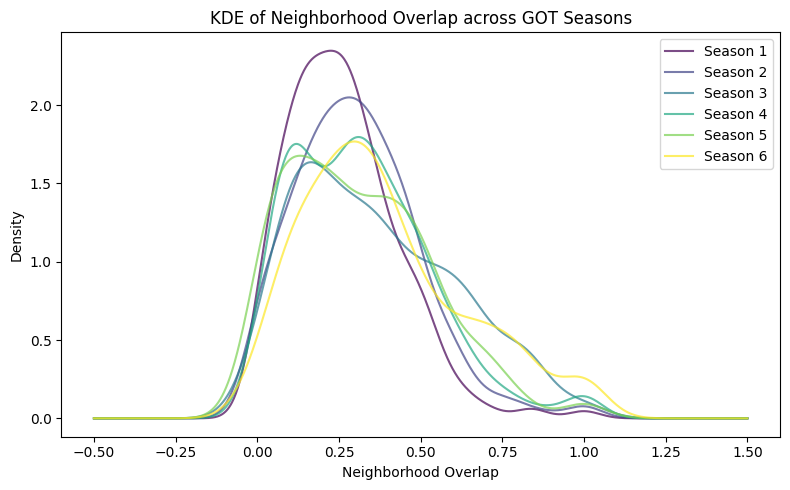

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df.boxplot()
plt.xlabel("Season")
plt.ylabel("Neighborhood Overlap")
plt.title("Distribution of Neighborhood Overlap across GOT Seasons")
plt.tight_layout()
plt.show()


import matplotlib.cm as cm

plt.figure(figsize=(8, 5))
colors = cm.viridis(np.linspace(0, 1, 6))
for (season, vals), color in zip(season_overlaps.items(), colors):
    pd.Series(vals).plot.kde(label=season, color=color, alpha=0.7)
plt.xlabel("Neighborhood Overlap")
plt.title("KDE of Neighborhood Overlap across GOT Seasons")
plt.legend()
plt.tight_layout()
plt.show()

## Failures and attacks on different topologies
* Generate three types of networks with the same number of nodes (500):
   - Erdős-Rényi random graph
   - Barabási-Albert scale-free graph
   - Watts-Strogatz small-world graph


In [26]:

networks = dict()
n = 500

p = 0.008  # This gives average degree around 4
networks['Erdős-Rényi'] = nx.erdos_renyi_graph(n, p)


m = 2 # m = 2 gives average degree around 4
networks['Barabási-Albert'] = nx.barabasi_albert_graph(n, m)


# k = 4, p = 0.1 for small-world properties
k = 4
p_rewire = 0.1
networks['Watts-Strogatz'] = nx.watts_strogatz_graph(n, k, p_rewire)

In [27]:
for name, graph in networks.items():
  print(name, graph)

Erdős-Rényi Graph with 500 nodes and 998 edges
Barabási-Albert Graph with 500 nodes and 996 edges
Watts-Strogatz Graph with 500 nodes and 1000 edges


* For each network:
   - Calculate the Molloy-Reed threshold
   - Compute the breakdown threshold
   - Simulate random failures (random node removal) and targeted attacks (high-degree first)
   - Plot the giant component size vs. fraction of removed nodes

In [28]:
degrees = dict()
for name, graph in networks.items():
  degrees[name] = list(dict(graph.degree()).values())

print('name', 'MR', 'BT')
for name, deg in degrees.items():
  print(name, molloy_reed(deg), breakdown_threshold(deg))

name MR BT
Erdős-Rényi 4.992 0.7494989979959921
Barabási-Albert 4.984 0.748995983935743
Watts-Strogatz 5.0 0.75


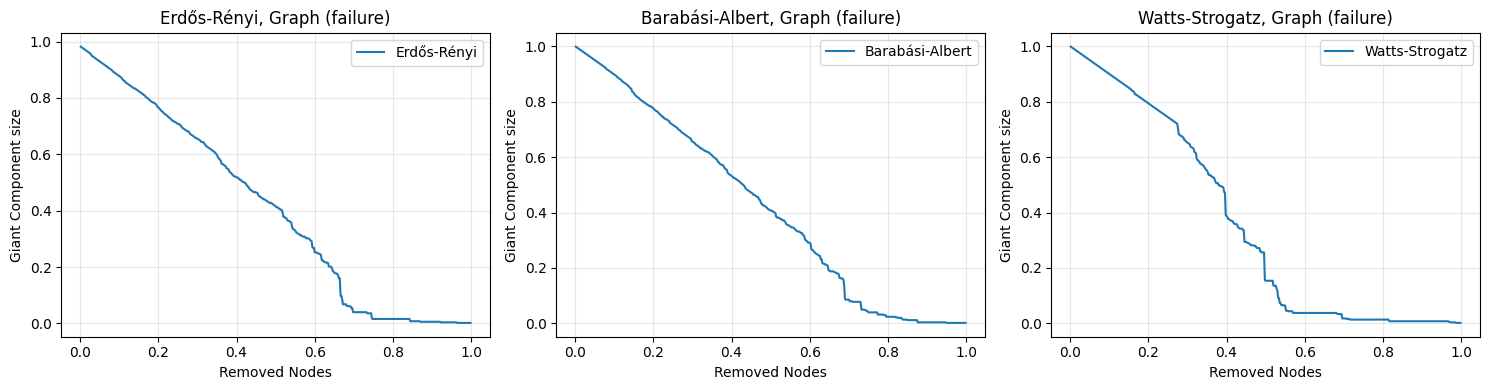

In [29]:
n_graphs = 3
fig, axes = plt.subplots(1, n_graphs, figsize=(5*n_graphs, 4))



for i, (name, graph) in enumerate(networks.items()):

    # Make a copy of the graph since dismantle modifies it
    g_copy = graph.copy()
    x, y = dismantle(g_copy, random_node)
    plot_dismantle(x, y, ax=axes[i], label=name)

    axes[i].set_title(f'{name}, Graph (failure)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

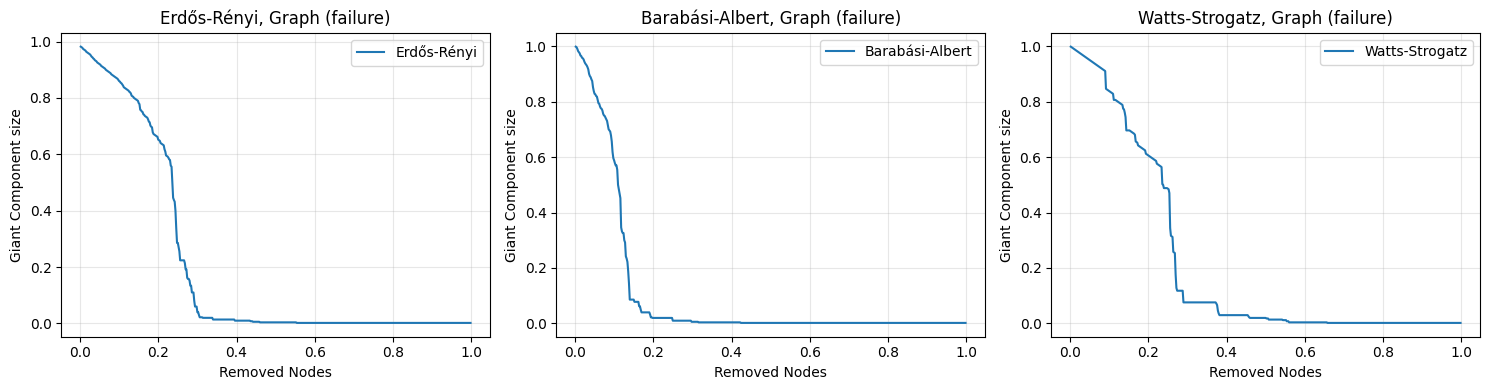

In [30]:
fig, axes = plt.subplots(1, n_graphs, figsize=(5*n_graphs, 4))

for i, (name, graph) in enumerate(networks.items()):

    # Make a copy of the graph since dismantle modifies it
    g_copy = graph.copy()
    x, y = dismantle(g_copy, get_sorted_nodes, score=nx.degree)
    plot_dismantle(x, y, ax=axes[i], label=name)

    axes[i].set_title(f'{name}, Graph (failure)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()